In [28]:
import pandas as pd
import json
import numpy as np
import math
from pandas import Series
from collections import Counter
import re
import spacy
import sklearn
import os
from IPython.display import clear_output

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def load_jsons(data_path, file):
    """ helper function to load '.json' files (they're not proper jsons) """
    file_path = data_path + file
    with open(file_path) as jsons:
        lines = [json.loads(json_line) for json_line in jsons]
    return pd.DataFrame(lines)

In [3]:
# Load data for one town
town = 'markham'
#town = 'ambridge'
data_path = './data/'+ town + '/'
review_file = 'review.json'
business_file = 'business.json'
user_file = 'user.json'
tip_file = 'tip.json'
checkin_file = 'checkin.json'

reviews = load_jsons(data_path, review_file)
businesses = load_jsons(data_path, business_file)
users = load_jsons(data_path, user_file)
tips = load_jsons(data_path, tip_file)
checkins = load_jsons(data_path, checkin_file)

reviews

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3.0,5,4,5,Tracy dessert had a big name in Hong Kong and ...,2016-05-07 01:21:02
1,9cW1B-T6M3ER3_rH_36h9Q,D-vYE3HILl7Qk1UhYqZXYQ,6sATfFam9_q9uod0I2aCsg,5.0,1,0,0,I really enjoyed my visit here.\nEverything wa...,2014-02-05 18:07:17
2,-W5OFbi3nixHZ0DTJmFK-w,h_2NGTYvjOc38cjx90rM5Q,b7e60tdyJxT_l-cstvMbfw,5.0,0,0,0,Just took the 6:30am class - My muscles have b...,2016-12-19 13:07:58
3,SWWVBFpSIsaWCgVePls5Yw,9lBu5VMrZpZEmp6scDYoaA,TtMRSbakzmWvfDDo5Ni3Hg,5.0,1,0,1,I remember going to this salon a few years ago...,2018-05-28 20:41:46
4,S7eyLPcXJLeD902kGeIHLA,-V-bzlNcuQc0otRfYKbZDg,6sATfFam9_q9uod0I2aCsg,1.0,0,0,0,I have taken my family to this place before. ...,2016-04-23 01:57:02
...,...,...,...,...,...,...,...,...,...
51297,RrZrL5RrMUY_Vu4yaFY3HA,tU94-C1zpBsfGFvpsJJr2w,NdPbp-3uQKGnOpPo3s2Y8g,2.0,4,0,1,What exactly is chunky chicken? Another fried ...,2017-07-17 17:21:19
51298,Ddo7AzBoF-EUJSK2PjMbhQ,QUq_hpZgISI0fOrUQF9fnQ,4Yi3mOofceLVKxiGDPBqMw,1.0,0,0,0,had a craving for noodle soup last week and we...,2010-06-22 02:31:24
51299,ocnlLjpWrb5-ADPkCt_S-g,ryI5QW93_-CfCEUX1jpW-g,sG3MhGiT3oSyzHdHLtWRyQ,4.0,1,0,1,Was in the area and was also shopping at J-Tow...,2017-04-30 03:06:50
51300,gw9wLuYYWZok2_Qfp91LtQ,bioStwWPi7JaL0IYmpZ6Ig,NzCGUsvkcBqCC8IGpTaUjg,2.0,0,0,0,Finally needed to review after being quite fed...,2016-07-24 16:27:55


In [4]:
"neemt het gemiddelde van de reviews voor elk business/user-koppel, om duplicates te voorkomen"
def mean_duplicates(reviews):
    group_bus = reviews.groupby(['business_id', 'user_id']).mean()
    group_bus = group_bus.reset_index()
    return group_bus

reviews_fixed = mean_duplicates(reviews)
reviews_fixed

,business_id,user_id,stars,useful,funny,cool
0,-0DET7VdEQOJVJ_v6klEug,-DPkNlW9tR4qfZpoQW4Vjg,4.0,1.0,0.0,0.0
1,-0DET7VdEQOJVJ_v6klEug,-HlCe-Ya-4CE2huuEk2_1g,3.0,1.0,0.0,0.0
2,-0DET7VdEQOJVJ_v6klEug,-P3SyBLmBhyhDcYatlBgBQ,1.0,2.0,0.0,0.0
3,-0DET7VdEQOJVJ_v6klEug,-qttTkWNXN_6bQd1RrcYlQ,2.0,0.0,0.0,0.0
4,-0DET7VdEQOJVJ_v6klEug,0mA20efXUsFthfMHY-9ZXA,4.0,0.0,0.0,0.0
...,...,...,...,...,...,...
49574,zxy7kNPVHsqmKKn7fmGnQA,YVGsWcFYjqjjylSBXKnsig,1.0,1.0,1.0,0.0
49575,zxy7kNPVHsqmKKn7fmGnQA,_1wzxXPApyRkboBmlv7Mzg,2.0,1.0,1.0,0.0
49576,zxy7kNPVHsqmKKn7fmGnQA,eghbpqq97hpuLHMgt1de-w,4.0,0.0,0.0,0.0
49577,zxy7kNPVHsqmKKn7fmGnQA,in8Cz6pRJO1tQ5fwKuW7TQ,1.0,0.0,1.0,0.0


In [5]:
def utility_matrix(reviews):
    """ takes a rating table as input and computes the utility matrix """

    return reviews.pivot(index='business_id', columns='user_id', values='stars')

In [6]:
""" Selecteert alle bedrijven met meer dan 35 reviews en gebruikt dan het resultaat
    om te kijken welke users hierin meer dan 15 reviews hebben"""
def select_above_x(df, what, amount):
    groups = df.groupby(what)
    a = groups[what]
    count = a.count()
    count2 = count[count >= amount]
    lijst = count2.index.tolist()
    return df[df[what].isin(lijst)] 

## Collaborative filtering

In [55]:
def get_rating(reviews, user_id, business_id):
    """Given a userId and movieId, this function returns the corresponding rating.
       Should return NaN if no rating exists."""
    if ((reviews['user_id'] == user_id) & (reviews['business_id'] == business_id)).any() == False:
        return np.nan
    else: 
        reviews_new = reviews.loc[reviews['user_id'] == user_id]
        reviews_new2 = reviews_new.loc[reviews['business_id'] == business_id]
    
        return float(reviews_new2['stars'])
    
get_rating(reviews_fixed, '-DPkNlW9tR4qfZpoQW4Vjg','-0DET7VdEQOJVJ_v6klEug')

4.0

In [56]:
def similarity_cosine(matrix, id1, id2):
    selected_features = matrix.loc[id1].notna() & matrix.loc[id2].notna()
    
    # if no matching features, return 'not a number' (NaN)
    if not selected_features.any():
        return np.nan
    
    # get the features from the matrix
    a = matrix.loc[id1][selected_features]
    b = matrix.loc[id2][selected_features]
    
    # compute the distances for the features
    if (np.sqrt(sum((a**2))) * np.sqrt(sum(b**2))) == 0:
        return np.nan
    else:
        cosine = sum(a * b) / (np.sqrt(sum(a**2))*np.sqrt(sum(b**2)))
        return cosine

def create_similarity_matrix_cosine(matrix):
    """creates the similarity matrix based on cosine similarity"""
    similarity_matrix = pd.DataFrame(0, index=matrix.index, columns=matrix.index, dtype=float)
    for y in similarity_matrix.index:
        for x in similarity_matrix.columns:
            if y == x:
                similarity_matrix[y][x] = 1
            else:
                similarity_matrix[y][x] = similarity_cosine(matrix, y, x)
    
    return similarity_matrix

In [57]:
def mean_center_columns(matrix):
    return matrix.subtract(matrix.mean())

In [58]:
def select_neighborhood(similarities, ratings, k):
    """ selects all items with similarity > 0  """
    gezien = ratings.notna()
    neighborhood = similarities[similarities[similarities > 0].index & ratings[gezien].index]
    neighborhood = neighborhood.sort_values(ascending=False)
    return neighborhood.head(k)

In [59]:
def weighted_mean(neighborhood, ratings): 
    if ~neighborhood.any():
        return np.nan
    ratings = ratings[ratings.index.isin(neighborhood.index)]          
    return sum(ratings*neighborhood) / sum(neighborhood)     

In [60]:
def predicted_ratings(user_id, similarities, utilities, k):
    businesses = utilities[utilities[user_id].notna() == False][user_id]
    neighborhood = [select_neighborhood(similarity[bus], u[user_id], k) for bus in businesses.index]
    pred_rating = [weighted_mean(neigh, utilities[user_id]) for neigh in neighborhood]
    pred_rating_dict = dict()
            
    for i in range(len(businesses.index)):
        pred_rating_dict[businesses.index[i]] = pred_rating[i]
    
    pred_rating_dict = {k: v for k, v in sorted(pred_rating_dict.items(), key=lambda item: item[1], reverse=True)}
    return pred_rating_dict

# Item based

In [14]:
x = select_above_x(reviews_fixed, 'business_id', 35)
y = select_above_x(x, 'user_id', 15)

u = utility_matrix(y)

display(u)

user_id,-2kCxY7_aw5hOz7fJnGMbQ,-DPkNlW9tR4qfZpoQW4Vjg,-HlCe-Ya-4CE2huuEk2_1g,-P3SyBLmBhyhDcYatlBgBQ,-_2h2cJlBOWAYrfplMU-Cg,-qSGCdxXU_jv_P-7CjZpcQ,0CaDbJNVt0_DA0Tj9PpctA,0U52n_sqA9j6UmB4mNVT9A,0_iROv6FL4KCveV916IpTA,0cUzu82KJiE5_xZA0Iu3ZQ,...,yeg2yd2QiZBbXUOIXkTIiA,yfhchNS9zMnnIGYnRC218g,z0zlvlrYJSAvjsNAfSQpGQ,z4PBmnPcQnjB92Jyd9CRZw,z6gseuVl0cR7tRLQa_DXuQ,z9w399cBpCAKXhH_JA1AtQ,zBzXqRpuh9Ch8adXkDVWwA,zU5IzkcDkWZSxRiFfwLFMw,zrFqKcVeY2qaKJYptOU7zw,zrnrTczWS4XBGPvrVbhDJg
business_id,,,,,,,,,,,,,,,,,,,,,
-0DET7VdEQOJVJ_v6klEug,NaN,4.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-7EwIdxcRC5McO35DVfeSQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-DtaPJJ-beogNkDKusGhlA,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
-EKDN1BbaPQD4FTPD9YNCw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-F6uKOdNYRV3ejbn7MiVNA,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zCiQ61Z2Gra8TKM65qJueA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zLPs4wSjtfZxVy3WByt00g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zkU-WMio8g6dpRJ2Y2xqvQ,NaN,5.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN


In [15]:
centered_utility_matrix = mean_center_columns(u)
display(centered_utility_matrix)

similarity = create_similarity_matrix_cosine(centered_utility_matrix)
display(similarity)

user_id,-2kCxY7_aw5hOz7fJnGMbQ,-DPkNlW9tR4qfZpoQW4Vjg,-HlCe-Ya-4CE2huuEk2_1g,-P3SyBLmBhyhDcYatlBgBQ,-_2h2cJlBOWAYrfplMU-Cg,-qSGCdxXU_jv_P-7CjZpcQ,0CaDbJNVt0_DA0Tj9PpctA,0U52n_sqA9j6UmB4mNVT9A,0_iROv6FL4KCveV916IpTA,0cUzu82KJiE5_xZA0Iu3ZQ,...,yeg2yd2QiZBbXUOIXkTIiA,yfhchNS9zMnnIGYnRC218g,z0zlvlrYJSAvjsNAfSQpGQ,z4PBmnPcQnjB92Jyd9CRZw,z6gseuVl0cR7tRLQa_DXuQ,z9w399cBpCAKXhH_JA1AtQ,zBzXqRpuh9Ch8adXkDVWwA,zU5IzkcDkWZSxRiFfwLFMw,zrFqKcVeY2qaKJYptOU7zw,zrnrTczWS4XBGPvrVbhDJg
business_id,,,,,,,,,,,,,,,,,,,,,
-0DET7VdEQOJVJ_v6klEug,NaN,0.071429,-0.045455,-2.484043,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-7EwIdxcRC5McO35DVfeSQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-DtaPJJ-beogNkDKusGhlA,NaN,NaN,NaN,NaN,-0.25,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.431818,NaN,NaN,NaN,NaN,NaN
-EKDN1BbaPQD4FTPD9YNCw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-F6uKOdNYRV3ejbn7MiVNA,NaN,NaN,NaN,NaN,0.75,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zCiQ61Z2Gra8TKM65qJueA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zLPs4wSjtfZxVy3WByt00g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.255102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zkU-WMio8g6dpRJ2Y2xqvQ,NaN,1.071429,NaN,NaN,0.75,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.483871,NaN,NaN,NaN,NaN


business_id,-0DET7VdEQOJVJ_v6klEug,-7EwIdxcRC5McO35DVfeSQ,-DtaPJJ-beogNkDKusGhlA,-EKDN1BbaPQD4FTPD9YNCw,-F6uKOdNYRV3ejbn7MiVNA,-I7Vz5eDjc63xKmmt4Qx4g,-Lgj3gdQZiVngAEc1yALzw,0-8DTqVaY9RJU0PAWD2l6Q,0-jZq2P4eN7fRdt4Ls1QZQ,0C38ezzbBX-dWxpnnwYAzg,...,yZNQpafHtocxFS8Q3FQNKw,y__uQsz_5q-3yXKeMRFU9Q,yiVv6EtyjrIJ34BgB_O4vA,z2n5NPgKsb_fMnWq8bMLRw,zBd5JvFWuMGlnCYLaGsXZg,zCiQ61Z2Gra8TKM65qJueA,zLPs4wSjtfZxVy3WByt00g,zkU-WMio8g6dpRJ2Y2xqvQ,zoIEe7uhsQT2EyiFLIfhrw,zs710LuQ8y10YsQHIjxjyw
business_id,,,,,,,,,,,,,,,,,,,,,
-0DET7VdEQOJVJ_v6klEug,1.000000,-0.159589,-0.558659,0.971403,-0.907118,-0.314167,-0.209057,0.385132,0.226523,-0.620176,...,-0.661388,-0.327261,0.466878,-0.789836,0.012184,-0.657127,-0.441926,0.412746,-0.722231,-0.748166
-7EwIdxcRC5McO35DVfeSQ,-0.159589,1.000000,-0.419796,-0.230850,-0.055886,1.000000,-0.256124,0.297358,-1.000000,NaN,...,1.000000,-0.608941,NaN,0.475084,-0.275215,0.747298,-1.000000,0.486594,0.024786,-0.280983
-DtaPJJ-beogNkDKusGhlA,-0.558659,-0.419796,1.000000,-0.802750,0.357713,0.399465,0.961461,-0.866969,-0.882518,-0.945851,...,0.037119,-0.966201,1.000000,0.705235,-0.599630,-0.096934,1.000000,0.587032,-0.472371,-0.753417
-EKDN1BbaPQD4FTPD9YNCw,0.971403,-0.230850,-0.802750,1.000000,-0.901469,0.311255,-0.348143,1.000000,1.000000,1.000000,...,-1.000000,-0.237787,NaN,-0.210822,0.753378,-1.000000,-0.982826,-0.702402,-0.461296,-0.861476
-F6uKOdNYRV3ejbn7MiVNA,-0.907118,-0.055886,0.357713,-0.901469,1.000000,0.560905,-0.907118,0.142751,-0.781991,-0.983911,...,0.398865,-1.000000,1.000000,-0.961216,-0.683563,-1.000000,NaN,0.167481,0.156561,-0.781991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zCiQ61Z2Gra8TKM65qJueA,-0.657127,0.747298,-0.096934,-1.000000,-1.000000,1.000000,0.045191,0.533396,-1.000000,1.000000,...,1.000000,1.000000,NaN,1.000000,0.051259,1.000000,0.217106,0.483302,-1.000000,0.539650
zLPs4wSjtfZxVy3WByt00g,-0.441926,-1.000000,1.000000,-0.982826,NaN,0.088429,0.569860,0.813628,-0.857946,-0.924826,...,1.000000,0.022246,1.000000,1.000000,0.096313,0.217106,1.000000,1.000000,0.204259,0.616322
zkU-WMio8g6dpRJ2Y2xqvQ,0.412746,0.486594,0.587032,-0.702402,0.167481,-1.000000,-0.103383,0.409050,-0.438082,0.246125,...,0.265905,-0.297362,-1.000000,0.147373,-0.097476,0.483302,1.000000,1.000000,-0.216993,0.711997


In [16]:
from math import ceil
#display(businesses)
# Categories: Restaurants, Shopping, Local Services, Other
def recommend_categories(rating_dict, k):
    """ Loops door rating_dict heen en geeft k recommendations terug
        amount zorgt ervoor dat categorie kleiner blijft dan 35% k 
        j is positie in rating_dict
        Other moet laatste blijven in categories
    """
    categories = {'Restaurants':0, 'Shopping':0, "Local Services":0, "Fitness & Instruction":0, "Other":0}
    amount = ceil(k/len(categories)) + ceil(k/10)
    recommend = list()
    keys = list(rating_dict.keys())
    df = businesses.set_index('business_id')
    j = 0

    while sum(categories.values()) < k :
        cat = df.loc[keys[j], 'categories']
        
        for x in categories.keys():
            if x in cat or x=='Other':
                if categories[x] == amount:
                    break
                else:
                    categories[x] +=1
                    recommend.append( (keys[j], x) )
                    break
                    
        j +=1
    return recommend

def to_results(rec_lijst):
    df = pd.DataFrame()
    lijst = list()
    for item in rec_lijst:
        #display(businesses.loc[businesses['business_id'] == item, ["name", 'address', 'city', 'state', 'is_open'] ])
        df = df.append( (businesses.loc[businesses['business_id'] == item[0], ["name", 'address', 'city', 'state', 'is_open'] ]), 
                  ignore_index=True) 
        lijst.append(item[1])
    df['category'] = lijst
    
    return df

x = predicted_ratings('-P3SyBLmBhyhDcYatlBgBQ', similarity, u, 10)           
display(to_results(recommend_categories(x, 20)))

,name,address,city,state,is_open,category
0,T & T Supermarket Unionville,"8339 Kennedy Road, Building C, G/F",Markham,ON,1,Other
1,Alchemy Coffee,"4361 Highway 7 E, Unit 1",Markham,ON,1,Restaurants
2,PaPa Chang's,"5970 16th Avenue, Unit 110",Markham,ON,1,Restaurants
3,Elegant Chinese Cuisine,"5328 Highway 7 E, Unit 4",Markham,ON,0,Restaurants
4,Love Gelato,75 Main Street N,Markham,ON,1,Other
5,Azyun Restaurant,"144 Main Street N, Unit 17",Markham,ON,1,Restaurants
6,Tangerine Asian Cuisine,"7690 Markham Road, Unit 4C",Markham,ON,1,Restaurants
7,Tasty House,3255 Highway 7 E,Markham,ON,1,Restaurants
8,The Alley,142 Main St Unionville,Markham,ON,1,Other
9,Igarage,"156 Bullock Drive, Unit 29",Markham,ON,1,Other


## User based

In [61]:
ub_u = utility_matrix(reviews_fixed).T

y_ub = select_above_x(reviews_fixed, 'business_id', 35)
x_ub = select_above_x(y_ub, 'user_id', 15)

ub_u_filtered = utility_matrix(x_ub).T

cum_ub = mean_center_columns(ub_u_filtered)
display(cum_ub)
display(x_ub)

business_id,-0DET7VdEQOJVJ_v6klEug,-7EwIdxcRC5McO35DVfeSQ,-DtaPJJ-beogNkDKusGhlA,-EKDN1BbaPQD4FTPD9YNCw,-F6uKOdNYRV3ejbn7MiVNA,-I7Vz5eDjc63xKmmt4Qx4g,-Lgj3gdQZiVngAEc1yALzw,0-8DTqVaY9RJU0PAWD2l6Q,0-jZq2P4eN7fRdt4Ls1QZQ,0C38ezzbBX-dWxpnnwYAzg,...,yZNQpafHtocxFS8Q3FQNKw,y__uQsz_5q-3yXKeMRFU9Q,yiVv6EtyjrIJ34BgB_O4vA,z2n5NPgKsb_fMnWq8bMLRw,zBd5JvFWuMGlnCYLaGsXZg,zCiQ61Z2Gra8TKM65qJueA,zLPs4wSjtfZxVy3WByt00g,zkU-WMio8g6dpRJ2Y2xqvQ,zoIEe7uhsQT2EyiFLIfhrw,zs710LuQ8y10YsQHIjxjyw
user_id,,,,,,,,,,,,,,,,,,,,,
-2kCxY7_aw5hOz7fJnGMbQ,NaN,NaN,NaN,NaN,NaN,NaN,1.056034,NaN,0.944444,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-DPkNlW9tR4qfZpoQW4Vjg,0.755556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.515625,NaN,NaN
-HlCe-Ya-4CE2huuEk2_1g,-0.244444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-P3SyBLmBhyhDcYatlBgBQ,-2.244444,NaN,NaN,NaN,NaN,NaN,0.056034,-1.189189,NaN,NaN,...,NaN,1.609375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-_2h2cJlBOWAYrfplMU-Cg,NaN,NaN,-0.619048,NaN,0.1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.515625,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
z9w399cBpCAKXhH_JA1AtQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.515625,-0.595238,NaN
zBzXqRpuh9Ch8adXkDVWwA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zU5IzkcDkWZSxRiFfwLFMw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,business_id,user_id,stars,useful,funny,cool
0,-0DET7VdEQOJVJ_v6klEug,-DPkNlW9tR4qfZpoQW4Vjg,4.0,1.0,0.0,0.0
1,-0DET7VdEQOJVJ_v6klEug,-HlCe-Ya-4CE2huuEk2_1g,3.0,1.0,0.0,0.0
2,-0DET7VdEQOJVJ_v6klEug,-P3SyBLmBhyhDcYatlBgBQ,1.0,2.0,0.0,0.0
7,-0DET7VdEQOJVJ_v6klEug,2ADk0EOfjlXfD2jOIrvkVw,3.0,2.0,0.0,0.0
9,-0DET7VdEQOJVJ_v6klEug,2bSX1ipFgI7AnWHvvjK2Yw,5.0,0.0,0.0,0.0
...,...,...,...,...,...,...
49498,zs710LuQ8y10YsQHIjxjyw,xDPfeRpE2946JJzuYf4C9w,3.0,0.0,0.0,0.0
49499,zs710LuQ8y10YsQHIjxjyw,y05H_1uQhO4frLTJ5_tGCQ,5.0,0.0,0.0,0.0
49501,zs710LuQ8y10YsQHIjxjyw,z0zlvlrYJSAvjsNAfSQpGQ,3.0,0.0,0.0,0.0
49502,zs710LuQ8y10YsQHIjxjyw,z4PBmnPcQnjB92Jyd9CRZw,4.0,0.0,0.0,0.0


In [62]:
sim_ub = create_similarity_matrix_cosine(cum_ub)
display(sim_ub)

user_id,-2kCxY7_aw5hOz7fJnGMbQ,-DPkNlW9tR4qfZpoQW4Vjg,-HlCe-Ya-4CE2huuEk2_1g,-P3SyBLmBhyhDcYatlBgBQ,-_2h2cJlBOWAYrfplMU-Cg,-qSGCdxXU_jv_P-7CjZpcQ,0CaDbJNVt0_DA0Tj9PpctA,0U52n_sqA9j6UmB4mNVT9A,0_iROv6FL4KCveV916IpTA,0cUzu82KJiE5_xZA0Iu3ZQ,...,yeg2yd2QiZBbXUOIXkTIiA,yfhchNS9zMnnIGYnRC218g,z0zlvlrYJSAvjsNAfSQpGQ,z4PBmnPcQnjB92Jyd9CRZw,z6gseuVl0cR7tRLQa_DXuQ,z9w399cBpCAKXhH_JA1AtQ,zBzXqRpuh9Ch8adXkDVWwA,zU5IzkcDkWZSxRiFfwLFMw,zrFqKcVeY2qaKJYptOU7zw,zrnrTczWS4XBGPvrVbhDJg
user_id,,,,,,,,,,,,,,,,,,,,,
-2kCxY7_aw5hOz7fJnGMbQ,1.000000,1.000000,NaN,-0.388781,1.000000,0.285146,-0.949755,1.000000,0.576124,-0.306256,...,0.479770,-0.248048,-0.963184,0.742905,NaN,0.651827,-0.841357,1.000000,NaN,-0.406043
-DPkNlW9tR4qfZpoQW4Vjg,1.000000,1.000000,-0.046960,-0.359285,-0.093292,1.000000,0.536374,0.195334,-0.580285,-0.999105,...,-0.178892,0.756048,-0.600316,-1.000000,1.000000,0.152775,NaN,-1.000000,-0.995125,0.112855
-HlCe-Ya-4CE2huuEk2_1g,NaN,-0.046960,1.000000,0.147742,-0.911104,-0.920980,-0.567444,0.367236,-0.475578,0.927436,...,0.247561,-0.601587,-0.629561,0.734969,-0.717621,-1.000000,-1.000000,-1.000000,-0.209515,-0.239645
-P3SyBLmBhyhDcYatlBgBQ,-0.388781,-0.359285,0.147742,1.000000,1.000000,0.271540,1.000000,-0.359992,-0.390822,0.345474,...,-0.417033,-0.238550,0.199304,-1.000000,-0.439652,0.661632,1.000000,0.518230,0.416263,-0.123385
-_2h2cJlBOWAYrfplMU-Cg,1.000000,-0.093292,-0.911104,1.000000,1.000000,-1.000000,-1.000000,0.549991,NaN,NaN,...,0.429704,0.473117,0.835136,NaN,-0.658799,0.045143,NaN,-1.000000,-1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
z9w399cBpCAKXhH_JA1AtQ,0.651827,0.152775,-1.000000,0.661632,0.045143,1.000000,-0.683554,-0.759151,-0.114824,0.054588,...,-0.447719,-0.098710,-0.619039,0.513741,NaN,1.000000,1.000000,0.993558,0.169987,-0.416408
zBzXqRpuh9Ch8adXkDVWwA,-0.841357,NaN,-1.000000,1.000000,NaN,1.000000,1.000000,-0.613901,NaN,-0.351643,...,-0.705924,NaN,0.163435,0.752325,-1.000000,1.000000,1.000000,0.207902,-0.269475,0.893544
zU5IzkcDkWZSxRiFfwLFMw,1.000000,-1.000000,-1.000000,0.518230,-1.000000,0.707431,NaN,-0.786674,0.931792,0.380653,...,-0.698354,NaN,0.083894,1.000000,NaN,0.993558,0.207902,1.000000,0.996131,1.000000


# Content based

In [17]:
"""Geef een dataframe met alle business ID's onder elkaar, filtered! aan de hand van de utility matrix
     Maak een frame met alle reviews in 1 doc en unieke business ID's voor NLP analyse """

def sortFrame(reviews,filtUtil):
    for r in reviews.index:
        if reviews['business_id'].loc[r] not in filtUtil.index:
            reviews = reviews.drop(r)
    
    return reviews.sort_values(by='business_id')

def orderedFrame(frame):
    sim = {}
    
    for r in frame['business_id']:
        if r not in sim.keys():
            sim[r] = [frame[frame['business_id'] == r]['text'].sum()]

    return pd.DataFrame(pd.Series(sim))

srt = sortFrame(reviews,u)
srt


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
4725,iT_0C2SnJil6La-_nODxSA,rkSr892_ic2OW0vMVe6n8Q,-0DET7VdEQOJVJ_v6klEug,3.0,0,0,0,I have been to this place since it was called ...,2017-06-07 21:50:09
7990,bITcoVCS1SgHYSsbPodNCw,Xg1m5ut-8_BckTRqd6z6dg,-0DET7VdEQOJVJ_v6klEug,2.0,0,0,0,I didn't really like this place at all. I orde...,2017-11-16 23:17:02
6105,pVjiObULVe5b_0FZRr9iOg,ZoNEuIMtwJ4BFTG5zs7aqQ,-0DET7VdEQOJVJ_v6klEug,4.0,0,0,0,"Compared to Aka Teppan, they have a much large...",2017-05-30 04:13:57
8017,HS5BYboS72WNgxasjQ7osA,HdCu089iVziXTJ7ptnTblg,-0DET7VdEQOJVJ_v6klEug,2.0,0,0,0,Food was average and pricey for what it is. \n...,2017-05-23 02:30:38
6071,RqwEYvzksALWCoPolS96CQ,b54joGtT-z6kqdmjEGFZcQ,-0DET7VdEQOJVJ_v6klEug,4.0,0,0,0,My friend and I originally came here because w...,2017-09-02 04:49:46
...,...,...,...,...,...,...,...,...,...
38526,CAhNnjgaRmXVh2AEcnewsQ,FDl069IeJurBKqPVvTENew,zs710LuQ8y10YsQHIjxjyw,5.0,0,0,0,Delicious and cheap. The steam dumplings are t...,2014-11-23 07:17:09
38485,_qFlddjKTwtKaw44lHO1Ng,4yGImSwdU9FZxVQIbZql3w,zs710LuQ8y10YsQHIjxjyw,4.0,1,0,0,Only a day before I was at Dumpling House Rest...,2014-05-19 13:35:08
37686,jFfrs0-_1HKqALYIn8EVpw,wSHVgeTB-4xCopHun51eVA,zs710LuQ8y10YsQHIjxjyw,4.0,3,2,2,4.5 stars. A really good cheap eats!\n\nRecent...,2016-03-14 16:28:27
38857,6LRjWosgzYRCqyA2droNBQ,EyYVD9n7PlYYLTSEQ5t14w,zs710LuQ8y10YsQHIjxjyw,3.0,0,0,0,My name is Arlene and I am addicted to dumplin...,2016-07-11 01:23:54


In [18]:
""" Usable dataframe voor NLP analyse """

rev= orderedFrame(srt)
rev


,0
-0DET7VdEQOJVJ_v6klEug,[I have been to this place since it was called...
-7EwIdxcRC5McO35DVfeSQ,"[I've been here many times before, but today w..."
-DtaPJJ-beogNkDKusGhlA,[All the grand opening specials are gone :(\nT...
-EKDN1BbaPQD4FTPD9YNCw,[Another bubble tea place. Tried the large man...
-F6uKOdNYRV3ejbn7MiVNA,[Front desk are nice but they def dont go the ...
...,...
zCiQ61Z2Gra8TKM65qJueA,[I'm so glad this place exists.\n\nReasonably ...
zLPs4wSjtfZxVy3WByt00g,"[If you love board games, bubble tea and escap..."
zkU-WMio8g6dpRJ2Y2xqvQ,[I went for dim sum lunch. Everything tasted ...
zoIEe7uhsQT2EyiFLIfhrw,[Service : 1/5\nEnvironment : 2.5 / 5\nFood & ...


In [20]:
""" Veel voorkomende, niet veel zeggende woorden """

STOPWORDS = {
    'a', 'able', 'about', 'across', 'after', 'all', 'almost', 'also', 
    'am', 'among', 'an', 'and', 'any', 'are', 'as', 'at', 
    'be', 'because', 'been', 'but', 'by', 'can', 'cannot', 'could', 
    'dear', 'did', 'do', 'does', 'either', 'else', 'ever', 'every', 
    'for', 'from', 'get', 'got', 'had', 'has', 'have', 'he', 
    'her', 'hers', 'him', 'his', 'how', 'however', 'i', 'if', 
    'in', 'into', 'is', 'it', 'its', 'just', 'least', 'let', 
    'like', 'likely', 'may', 'me', 'might', 'most', 'must', 
    'my', 'neither', 'no', 'nor', 'not', 'of', 'off', 'often', 
    'on', 'only', 'or', 'other', 'our', 'own', 'rather', 'said', 
    'say', 'says', 'she', 'should', 'since', 'so', 'some', 'than', 
    'that', 'the', 'their', 'them', 'then', 'there', 'these', 'they', 
    'this', 'tis', 'to', 'too', 'twas', 'us', 'wants', 'was', 
    'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 
    'whom', 'why', 'will', 'with', 'would', 'yet', 'you', 'your','go','word'}

""" Woorden die enchant niet pakt als woorden ivm geen hoofdletter aanwezig """
 
FOODWORDS = {'italian','japanese','chinese','flavoured','gastropubs','indonesian',
             'mediterranean','german','thai','vietnamese','belgian','dutch','caribbean','mexican','korean',
            'canadian','asian','taiwanese','spanish','hong','poke','hawaiian','burmese','signaporean',
            'greek','dim','indian','fillipino'}

In [21]:
""" Lemmas en bag of words functies, take doc en return series.
 enchant is een dict functie waardoor een woord gecheckt kan worden of het een bestaand Engels woord is """

import enchant
from sklearn.feature_extraction.text import CountVectorizer

def lemmas(doc):
    """
    Returns a list of lemmas 
    """
    return [word.lemma_ for word in doc if word.is_alpha and not (word.is_punct or word.is_space or word.is_stop)]

def bag_of_words(doc):
    """
    Takes a spaCy doc and returns a bag of words.
    Does not include any punctuation, whitespace or stop words in the resulting bag.
    """
    doc = lemmas(nlp(doc[0]))
    d = enchant.Dict("en_US")

    vect = CountVectorizer()
    vect.fit(doc)
    
    bag = pd.Series(vect.vocabulary_)

    for b in bag.index:
        if b in FOODWORDS:
            pass
        elif b in STOPWORDS or d.check(b) == False:
            bag = bag.drop(b)
            
    return bag


In [22]:
bags = rev[0].map(bag_of_words)
bags


-0DET7VdEQOJVJ_v6klEug    place          871
call           152
aka     ...
-7EwIdxcRC5McO35DVfeSQ    time           1568
today          1575
lamp  ...
-DtaPJJ-beogNkDKusGhlA    grand      316
opening    506
special    710
t...
-EKDN1BbaPQD4FTPD9YNCw    bubble        67
tea          651
place       ...
-F6uKOdNYRV3ejbn7MiVNA    desk          450
nice         1082
def       ...
                                                ...                        
zCiQ61Z2Gra8TKM65qJueA    glad          274
place         483
exist     ...
zLPs4wSjtfZxVy3WByt00g    love          753
board         138
game      ...
zkU-WMio8g6dpRJ2Y2xqvQ    dim         389
sum        1406
lunch       82...
zoIEe7uhsQT2EyiFLIfhrw    service        1024
environment     382
food  ...
zs710LuQ8y10YsQHIjxjyw    commerce     217
court        248
decide      ...
Name: 0, Length: 369, dtype: object

In [23]:
def term_frequency(bag):
    """Takes in a bag of words, returns the term frequency of every term in bag as a Series."""
    # TODO
    return pd.Series(bag/bag.sum())

def inverse_document_frequency(bags):
    """Takes in a Series of bag of words, returns the IDF for every term in the bags in a Series."""
    # TODO 
    counts = [] 
    idf = {}
    
    for b in bags:
        for w in b.index:
            counts.append(w)
            
    for c in counts:
        if c not in idf.keys():
            idf[c] = math.log(len(bags)/counts.count(c))

    return pd.Series(idf)

def tf_idf(bag, idf):
    """
    Takes in a bag of words and a Series containing IDF scores, 
    returns tf_idf score for every word in bag as a Series
    """
    # TODO
    tfidf = {}

    tf = term_frequency(bag)
    for b in tf.index:
            tfidf[b] = tf.loc[b] * idf.loc[b]
        
    return pd.Series(tfidf) 


In [24]:
""" Dataframe met business id's occurances = 1 """

def oneBusinessId(frame):
    wordUtil = pd.DataFrame()

    her = []
    for t in frame['business_id']:
        if t not in her:
            her.append(t)
            wordUtil[t] = [srt[srt['business_id'] == t]['stars'].mean()]
            
    return wordUtil.T
        
stars_words = oneBusinessId(srt)
stars_words

,0
-0DET7VdEQOJVJ_v6klEug,3.150943
-7EwIdxcRC5McO35DVfeSQ,3.765625
-DtaPJJ-beogNkDKusGhlA,3.731707
-EKDN1BbaPQD4FTPD9YNCw,2.638889
-F6uKOdNYRV3ejbn7MiVNA,3.260870
...,...
zCiQ61Z2Gra8TKM65qJueA,3.595238
zLPs4wSjtfZxVy3WByt00g,4.171171
zkU-WMio8g6dpRJ2Y2xqvQ,3.546296
zoIEe7uhsQT2EyiFLIfhrw,3.404959


In [25]:
""" Maak de utility matrix voor NLP analyse - dit is dus met woorden """

def util(bags):
    bag_idf = inverse_document_frequency(bags)

    utill = {}
    
    for i in range(len(bags)):
        #print(i,'i',stars_words.index[i])
        utill[stars_words.index[i]] = tf_idf(bags[i], bag_idf).sort_values(ascending=False)[:30]

    utility = pd.DataFrame(utill)
    utility = utility.fillna(0)

    for y in utility.index:
        for x in utility.columns:
            if utility[x].loc[y] != 0:
                utility[x].loc[y] = 1

    return utility.T
            
utility_matrix_training = util(bags)
utility_matrix_training

    

,flattop,flies,framed,freeway,funeral,funnily,fussing,garb,garvey,generosity,...,zodiac,zombie,zombies,zone,zoning,zoo,zoom,zucchini,zucchinis,éclair
-0DET7VdEQOJVJ_v6klEug,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-7EwIdxcRC5McO35DVfeSQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-DtaPJJ-beogNkDKusGhlA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-EKDN1BbaPQD4FTPD9YNCw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-F6uKOdNYRV3ejbn7MiVNA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zCiQ61Z2Gra8TKM65qJueA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
zLPs4wSjtfZxVy3WByt00g,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zkU-WMio8g6dpRJ2Y2xqvQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zoIEe7uhsQT2EyiFLIfhrw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
""" Similarity matrix voor NLP analyse """

def create_similarity_matrix_jaccard(matrix):
    m11 = matrix @ matrix.T
    m10 = pd.DataFrame(matrix.sum(axis = 1).values + np.zeros(m11.shape), index = m11.index, columns = m11.index)
    m01 = m10.T
    return m11/(m01 + m10 - m11)
    
    
siml_matrix = create_similarity_matrix_jaccard(utility_matrix_training)
display(siml_matrix)
    

,-0DET7VdEQOJVJ_v6klEug,-7EwIdxcRC5McO35DVfeSQ,-DtaPJJ-beogNkDKusGhlA,-EKDN1BbaPQD4FTPD9YNCw,-F6uKOdNYRV3ejbn7MiVNA,-I7Vz5eDjc63xKmmt4Qx4g,-Lgj3gdQZiVngAEc1yALzw,0-8DTqVaY9RJU0PAWD2l6Q,0-jZq2P4eN7fRdt4Ls1QZQ,0C38ezzbBX-dWxpnnwYAzg,...,yZNQpafHtocxFS8Q3FQNKw,y__uQsz_5q-3yXKeMRFU9Q,yiVv6EtyjrIJ34BgB_O4vA,z2n5NPgKsb_fMnWq8bMLRw,zBd5JvFWuMGlnCYLaGsXZg,zCiQ61Z2Gra8TKM65qJueA,zLPs4wSjtfZxVy3WByt00g,zkU-WMio8g6dpRJ2Y2xqvQ,zoIEe7uhsQT2EyiFLIfhrw,zs710LuQ8y10YsQHIjxjyw
-0DET7VdEQOJVJ_v6klEug,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.016949,0.000000,0.016949,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-7EwIdxcRC5McO35DVfeSQ,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.016949,0.000000,0.000000,0.000000,0.000000
-DtaPJJ-beogNkDKusGhlA,0.0,0.000000,1.000000,0.016949,0.0,0.000000,0.016949,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.016949,0.000000
-EKDN1BbaPQD4FTPD9YNCw,0.0,0.000000,0.016949,1.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.034483,0.000000,0.000000,0.000000,0.016949
-F6uKOdNYRV3ejbn7MiVNA,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zCiQ61Z2Gra8TKM65qJueA,0.0,0.016949,0.000000,0.034483,0.0,0.000000,0.000000,0.000000,0.0,0.016949,...,0.000000,0.000000,0.016949,0.0,0.016949,1.000000,0.016949,0.000000,0.000000,0.000000
zLPs4wSjtfZxVy3WByt00g,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.016949,1.000000,0.016949,0.000000,0.000000
zkU-WMio8g6dpRJ2Y2xqvQ,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.016949,1.000000,0.000000,0.000000
zoIEe7uhsQT2EyiFLIfhrw,0.0,0.000000,0.016949,0.000000,0.0,0.016949,0.016949,0.016949,0.0,0.000000,...,0.016949,0.016949,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000


## Tim's stuk

In [27]:
def replace_genre(text):
    return text.replace(', ','|')

businesses["categories"] = (businesses["categories"].map(str)).map(replace_genre)

def categories(businesses):
    """Create an unfolded genre dataframe. Unpacks genres seprated by a '|' into seperate rows.

    Arguments:
    movies -- a dataFrame containing at least the columns 'movieId' and 'genres' 
              where genres are seprated by '|'
    """
    genres_m = businesses.apply(lambda row: pd.Series([row['business_id']] + row['categories'].split("|")), axis=1)
    stack_genres = genres_m.set_index(0).stack()
    df_stack_genres = stack_genres.to_frame()
    df_stack_genres['business_id'] = stack_genres.index.droplevel(1)
    df_stack_genres.columns = ['categories', 'business_id']
    return df_stack_genres.reset_index()[['business_id', 'categories']]

df_genres = categories(businesses)
df_genres

,business_id,categories
0,HBQG_DT8pfbkv8jiv3P6Gw,Shopping
1,HBQG_DT8pfbkv8jiv3P6Gw,Discount Store
2,YOhtdvjmveAtsblep0CQrg,Fitness & Instruction
3,YOhtdvjmveAtsblep0CQrg,Yoga
4,YOhtdvjmveAtsblep0CQrg,Education
...,...,...
6367,sVEE_Mp3EbWW1UIhfActVA,Seafood
6368,sVEE_Mp3EbWW1UIhfActVA,Specialty Food
6369,sVEE_Mp3EbWW1UIhfActVA,Thai
6370,sVEE_Mp3EbWW1UIhfActVA,Ethnic Food


In [28]:
def pivot_categories(df):
    """Create a one-hot encoded matrix for genres.
    
    Arguments:
    df -- a dataFrame containing at least the columns 'movieId' and 'genre'
    
    Output:
    a matrix containing '0' or '1' in each cell.
    1: the movie has the genre
    0: the movie does not have the genre
    """
    return df.pivot_table(index = 'business_id', columns = 'categories', aggfunc = 'size', fill_value=0)

df_utility_genres = pivot_categories(df_genres)
display(df_utility_genres.head())

categories,Accessories,Active Life,Acupuncture,Afghan,Airport Shuttles,Amateur Sports Teams,American (New),American (Traditional),Amusement Parks,Appliances,...,Wedding Planning,Weight Loss Centers,Wholesale Stores,Wigs,Windshield Installation & Repair,Wine & Spirits,Wine Bars,Women's Clothing,Yelp Events,Yoga
business_id,,,,,,,,,,,,,,,,,,,,,
-0DET7VdEQOJVJ_v6klEug,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-0FA-Qdi3SPYIoJz9UQw-A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-0T0jfPnuBRdpNTXpOQZcA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-1LvG5O5lzfqUeti0Z3L5Q,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-2lSbNMhXKYu7URjEE59qA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
def similarity_matrix(matrix):
    m11 = matrix @ matrix.T
    m10 = pd.DataFrame(matrix.sum(axis = 1).values + np.zeros(m11.shape), index = m11.index, columns = m11.index)
    m01 = m10.T
    return m11/(m01 + m10 - m11)
    
    
display(similarity_matrix(df_utility_genres))
df_similarity_genres = similarity_matrix(df_utility_genres)

business_id,-0DET7VdEQOJVJ_v6klEug,-0FA-Qdi3SPYIoJz9UQw-A,-0T0jfPnuBRdpNTXpOQZcA,-1LvG5O5lzfqUeti0Z3L5Q,-2lSbNMhXKYu7URjEE59qA,-56TP_w4VG2oNGpauDMOOQ,-7EwIdxcRC5McO35DVfeSQ,-83ocSxK6d8m_oaaM5eO6w,-D24iSlpY6KhaDbi_bRv9g,-DDQoNUvrGe8d75OvCDRpQ,...,zicAwxhq82xVIPgbRIsmNg,zkOq9Z2InCTY1IbNCA7HDQ,zkU-WMio8g6dpRJ2Y2xqvQ,zkbJE4QFMZla-mnomfFC5w,zoIEe7uhsQT2EyiFLIfhrw,zs710LuQ8y10YsQHIjxjyw,ztX_39BrHP76S8Vv4Y9LIw,zuTA5DZ3FQL33hstBJktNQ,zutMSVmRLPjEbeF8aFtSnQ,zxy7kNPVHsqmKKn7fmGnQA
business_id,,,,,,,,,,,,,,,,,,,,,
-0DET7VdEQOJVJ_v6klEug,1.000000,0.000000,0.166667,0.000000,0.333333,0.285714,0.250000,0.000,0.000000,0.000000,...,0.166667,0.000000,0.250000,0.000000,0.000000,0.333333,0.000000,0.000000,0.100000,0.250000
-0FA-Qdi3SPYIoJz9UQw-A,0.000000,1.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.250,0.333333,0.666667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000
-0T0jfPnuBRdpNTXpOQZcA,0.166667,0.000000,1.000000,0.000000,0.166667,0.090909,0.142857,0.000,0.000000,0.000000,...,0.111111,0.000000,0.142857,0.166667,0.333333,0.166667,0.000000,0.285714,0.166667,0.333333
-1LvG5O5lzfqUeti0Z3L5Q,0.000000,0.000000,0.000000,1.000000,0.000000,0.125000,0.000000,0.000,0.000000,0.000000,...,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000
-2lSbNMhXKYu7URjEE59qA,0.333333,0.000000,0.166667,0.000000,1.000000,0.125000,0.250000,0.000,0.000000,0.000000,...,0.166667,0.000000,0.250000,0.000000,0.000000,0.333333,0.000000,0.000000,0.100000,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zs710LuQ8y10YsQHIjxjyw,0.333333,0.000000,0.166667,0.000000,0.333333,0.125000,0.666667,0.000,0.000000,0.000000,...,0.166667,0.000000,0.666667,0.000000,0.000000,1.000000,0.000000,0.000000,0.100000,0.250000
ztX_39BrHP76S8Vv4Y9LIw,0.000000,0.142857,0.000000,0.142857,0.000000,0.300000,0.000000,0.125,0.142857,0.125000,...,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
zuTA5DZ3FQL33hstBJktNQ,0.000000,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.200000,0.400000,0.000000,0.000000,1.000000,0.083333,0.166667


## Combined content

## recomending

In [93]:
import math
from math import ceil

""" Geeft een dict met bedrijven en de similarity scores, boven 0 """

def recommender(user_id, similarity, utility):
    
    user = pd.DataFrame(utility[user_id])
    
    new = {}
    for y in user.index:
        if math.isnan(user.loc[y]) == False:
            new[y] = user.loc[y]

    new = pd.DataFrame(new).T

    get_sim = {}
    for n in new.index:
        test = similarity[n][similarity[n] > 0]
        for s in test.index:
            if s != n:
                if s in get_sim.keys():
                    if get_sim[s] < test.loc[s]:
                        get_sim[s] = test.loc[s]
                else:
                    get_sim[s] = test.loc[s]


    return get_sim

def recommend_categories(rating_dict, k):
    """ Loops door rating_dict heen en geeft k recommendations terug
        amount zorgt ervoor dat categorie kleiner blijft dan 35% k 
        j is positie in rating_dict
        Other moet laatste blijven in categories
    """
    categories = {'Restaurants':0, 'Shopping':0, "Local Services":0, "Fitness & Instruction":0, "Other":0}
    amount = ceil(k/len(categories)) + ceil(k/10)
    recommend = list()
    keys = list(rating_dict.keys())
    df = businesses.set_index('business_id')
    j = 0

    while sum(categories.values()) < k :
        cat = df.loc[keys[j], 'categories']
        
        for x in categories.keys():
            if x in cat or x=='Other':
                if categories[x] == amount:
                    break
                else:
                    categories[x] +=1
                    recommend.append( (keys[j], x) )
                    break
                    
        j +=1
    return recommend

def to_results(rec_lijst):
    df = pd.DataFrame()
    lijst = list()
    for item in rec_lijst:
        #display(businesses.loc[businesses['business_id'] == item, ["name", 'address', 'city', 'state', 'is_open'] ])
        df = df.append( (businesses.loc[businesses['business_id'] == item[0], ["name", 'address', 'city', 'state', 'is_open'] ]), 
                  ignore_index=True) 
        lijst.append(item[1])
    df['category'] = lijst
    
    return df


simDict = recommender('-P3SyBLmBhyhDcYatlBgBQ', siml_matrix,u)
simDict_categories = recommender('-P3SyBLmBhyhDcYatlBgBQ', df_similarity_genres ,u)
display(to_results(recommend_categories(simDict, 20)))


,name,address,city,state,is_open,category
0,Daisuki Sushi,"9275 Highway 48, Suite 5",Markham,ON,0,Restaurants
1,Bagel Nash,7355 Bayview Avenue,Markham,ON,1,Other
2,Little Bangkok,227 Main Street,Markham,ON,1,Restaurants
3,After Queen Tea Shop,7355 Bayview Avenue,Markham,ON,1,Restaurants
4,Foody Mart,5221 Highway 7,Markham,ON,1,Other
5,Golden Duke Chinese Cuisine,"5284 Highway 7 E, Unit 3",Markham,ON,1,Restaurants
6,i Darts Toronto,"7850 Woodbine Avenue, Unit 228",Markham,ON,1,Other
7,Legend Pot,"7030 Warden Avenue, Unit D3",Markham,ON,1,Restaurants
8,Oriental Gourmet,5328 Highway 7 E,Markham,ON,1,Restaurants
9,Tung Tung Dan Quen King,"4300 Steeles Avenue E, Unit 106",Markham,ON,1,Other


In [94]:
display(to_results(recommend_categories(simDict_categories, 20)))

,name,address,city,state,is_open,category
0,Tim Hortons,9970 Highway 48,Markham,ON,1,Restaurants
1,Pho King,3636 Steeles Ave E,Markham,ON,1,Restaurants
2,Peachtree Mall,8380 Kennedy Road,Markham,ON,1,Restaurants
3,Xin Jiang Restaurant,3636 Steeles Avenue E,Markham,ON,1,Restaurants
4,Toro Sushi,8515 McCowan Road,Markham,ON,0,Restaurants
5,Go For Tea,13 - 179 Enterprise Boulevard,Markham,ON,1,Restaurants
6,Take One Karaoke & Lounge,7850 Woodbine Avenue,Markham,ON,1,Other
7,Area One KTV Lounge,7634 Woodbine Avenue,Markham,ON,0,Other
8,Hangover Sports Bar,7354 Woodbine Avenue,Markham,ON,0,Other
9,Encore Karaoke & Lounge,"8601 Warden Avenue, Unit 30",Markham,ON,0,Other


# Evaluaties

In [95]:
def mse(predicted_ratings):
    """Computes the mean square error between actual ratings and predicted ratings
    
    Arguments:
    predicted_ratings -- a dataFrame containing the columns rating and predicted rating
    """
    diff = predicted_ratings['stars'] - predicted_ratings['predicted rating']
    return (diff**2).mean()

In [96]:
def predict_ratings(similarity, utility, to_predict, filtering = "IB"):
    """Predicts the predicted rating for the input test data.
    
    Arguments:
    similarity -- a dataFrame that describes the similarity between items
    utility    -- a dataFrame that contains a rating for each user (columns) and each movie (rows). 
                  If a user did not rate an item the value np.nan is assumed. 
    to_predict -- A dataFrame containing at least the columns movieId and userId for which to do the predictions
    """
    # copy input (don't overwrite)
    ratings_test_c = to_predict.copy()
    # apply prediction to each row
    if filtering == 'IB':
        ratings_test_c['predicted rating'] = to_predict.apply(lambda row: predict_ids(similarity, utility, row['user_id'], row['business_id']), axis=1)
    elif filtering == 'UB':
        ratings_test_c['predicted rating'] = to_predict.apply(lambda row: predict_ids(similarity, utility, row['business_id'], row['user_id']), axis=1)
    
    return ratings_test_c

### Helper functions for predict_ratings_item_based ###

def predict_ids(similarity, utility, userId, itemId):
    # select right series from matrices and compute
    if userId in utility.columns and itemId in similarity.index:
        return predict_vectors(utility.loc[:,userId], similarity[itemId])
    return 1

def predict_vectors(user_ratings, similarities):
    # select only movies actually rated by user
    relevant_ratings = user_ratings.dropna()
    
    # select corresponding similairties
    similarities_s = similarities[relevant_ratings.index]
    
    # select neighborhood
    similarities_s = similarities_s[similarities_s > 0.0]
    relevant_ratings = relevant_ratings[similarities_s.index]
    
    # if there's nothing left return a prediction of 0
    norm = similarities_s.sum()
    if(norm == 0):
        return 1
    
    # compute a weighted average (i.e. neighborhood is all) 
    return np.dot(relevant_ratings, similarities_s)/norm

In [97]:
def recommended(predictions, treshold):
    return predictions[predictions['predicted rating'] > treshold]
    
def hidden(predictions, treshold):
    return predictions[predictions['predicted rating'] < treshold]

def used(predictions, treshold):
    return predictions[predictions['stars'] >= treshold]

def unused(predictions, treshold):
    return predictions[predictions['stars'] <= treshold]

def confusion(recommended, hidden, used, unused):
    tp = recommended.merge(used, how='inner').shape[0]
    fp = recommended.merge(unused, how='inner').shape[0]
    tn = hidden.merge(unused, how='inner').shape[0]
    fn = hidden.merge(used, how='inner').shape[0]
    
    confusion_matrix = pd.DataFrame([[tp, fp], [fn, tn]], columns=['used', 'unused'], index=['recommended', 'hidden'])
    return confusion_matrix


In [98]:
def precision(confusion_matrix):
    return confusion_matrix['used']['recommended'] / (confusion_matrix['used']['recommended'] + 
                                                      confusion_matrix['unused']['recommended'])

def recall(confusion_matrix):
    return confusion_matrix['used']['recommended'] / (confusion_matrix['used']['recommended'] + confusion_matrix['used']['hidden'])

def accuracy(matrix):
    TP = matrix['used']['recommended']
    FP = matrix['unused']['recommended']
    TN = matrix['unused']['hidden']
    FN = matrix['used']['hidden']
    acc = (TP + TN) / (TP + FP + TN + FN)
    return acc

def f1(matrix):
    prec = precision(matrix)
    rec = recall(matrix)
    if prec == 0 and rec == 0:
        return 0.0
    return 2 * ( (prec*rec) / (prec+rec) )

def mcc(matrix):
    TP = matrix['used']['recommended']
    FP = matrix['unused']['recommended']
    TN = matrix['unused']['hidden']
    FN = matrix['used']['hidden']
    teller = (TP * TN) - (FP * FN)
    noemer = np.sqrt((TP+FP) * (TP+FN) * (TN+FP) * (TN+FN))
    return teller/noemer
    


## Item based

In [99]:
testing = predict_ratings(similarity,u,y[['user_id', 'business_id', 'stars']])
ib_mse = mse(testing)

testing.head()

,user_id,business_id,stars,predicted rating
0,-DPkNlW9tR4qfZpoQW4Vjg,-0DET7VdEQOJVJ_v6klEug,4.0,4.119532
1,-HlCe-Ya-4CE2huuEk2_1g,-0DET7VdEQOJVJ_v6klEug,3.0,2.209042
2,-P3SyBLmBhyhDcYatlBgBQ,-0DET7VdEQOJVJ_v6klEug,1.0,2.543273
7,2ADk0EOfjlXfD2jOIrvkVw,-0DET7VdEQOJVJ_v6klEug,3.0,2.801994
9,2bSX1ipFgI7AnWHvvjK2Yw,-0DET7VdEQOJVJ_v6klEug,5.0,4.316499


In [100]:
treshold_recommended = 3.75
treshold_used = 4.0

recommended_items = recommended(testing, treshold_recommended)
hidden_items = hidden(testing, treshold_recommended)
used_items = used(testing, treshold_used)
unused_items = unused(testing, treshold_used)

confusion_matrix = confusion(recommended_items, hidden_items, used_items, unused_items)
display(confusion_matrix)

,used,unused
recommended,5089,3612
hidden,1332,7240


In [101]:
ib_acc = accuracy(confusion_matrix) 
print(ib_acc)
print(f1(confusion_matrix))
print(mcc(confusion_matrix))

0.7137729404272564
0.6730591191641317
0.4443427585498667


## User based

In [102]:
ub_testing = predict_ratings(sim_ub, ub_u_filtered, x_ub[['user_id', 'business_id', 'stars']], 'UB')
ub_mse = mse(ub_testing)

display(ub_testing.head())

,user_id,business_id,stars,predicted rating
0,-DPkNlW9tR4qfZpoQW4Vjg,-0DET7VdEQOJVJ_v6klEug,4.0,3.793812
1,-HlCe-Ya-4CE2huuEk2_1g,-0DET7VdEQOJVJ_v6klEug,3.0,2.584166
2,-P3SyBLmBhyhDcYatlBgBQ,-0DET7VdEQOJVJ_v6klEug,1.0,2.192187
7,2ADk0EOfjlXfD2jOIrvkVw,-0DET7VdEQOJVJ_v6klEug,3.0,2.767409
9,2bSX1ipFgI7AnWHvvjK2Yw,-0DET7VdEQOJVJ_v6klEug,5.0,4.060822


In [103]:
treshold_recommended = 3.75
treshold_used = 4.0

ub_recommended_items = recommended(ub_testing, treshold_recommended)
ub_hidden_items = hidden(ub_testing, treshold_recommended)
ub_used_items = used(ub_testing, treshold_used)
ub_unused_items = unused(ub_testing, treshold_used)

ub_confusion_matrix = confusion(ub_recommended_items, ub_hidden_items, ub_used_items, ub_unused_items)
display(ub_confusion_matrix)

,used,unused
recommended,5482,4003
hidden,939,6849


In [104]:
ub_acc = accuracy(ub_confusion_matrix)
print(ub_acc)
print(f1(ub_confusion_matrix))
print(mcc(ub_confusion_matrix))


0.7138887280727146
0.6892996353577266
0.47094145326806613


## Content based

In [105]:
predicted = predict_ratings(siml_matrix,u,y)
mse_cb = mse(predicted)

print(f'mse for content based filtering: {mse_cb:.2f}')

mse for content based filtering: 0.01


In [106]:
treshold_recommended = 3.75
treshold_used = 4.0

recommended_items = recommended(predicted, treshold_recommended)
hidden_items = hidden(predicted, treshold_recommended)
used_items = used(predicted, treshold_used)
unused_items = unused(predicted, treshold_used)

confusion_matrix = confusion(recommended_items, hidden_items, used_items, unused_items)
display(confusion_matrix)

,used,unused
recommended,6287,4731
hidden,134,6121


In [107]:
cb_acc = accuracy(confusion_matrix)
print(cb_acc)
print(f1(confusion_matrix))
print(mcc(confusion_matrix))



0.7183465524228565
0.721027581856758
0.5461733890055417


## Categories content

In [108]:
calculated = predict_ratings(df_similarity_genres,u,y)
mse_cb = mse(calculated)

print(f'mse for content based filtering: {mse_cb:.2f}')

mse for content based filtering: 0.61


In [109]:
treshold_recommended = 3.75
treshold_used = 4.0

recommended_items = recommended(calculated, treshold_recommended)
hidden_items = hidden(calculated, treshold_recommended)
used_items = used(calculated, treshold_used)
unused_items = unused(calculated, treshold_used)

confusion_matrix = confusion(recommended_items, hidden_items, used_items, unused_items)
display(confusion_matrix)

,used,unused
recommended,2269,1541
hidden,4152,9311


In [110]:
cb_acc = accuracy(confusion_matrix)
print(cb_acc)
print(f1(confusion_matrix))
print(mcc(confusion_matrix))



0.6704104672031495
0.4435539047991399
0.24635803324134453


# Evaluatie grafieken

In [111]:
import matplotlib.pyplot as plt

## Item based

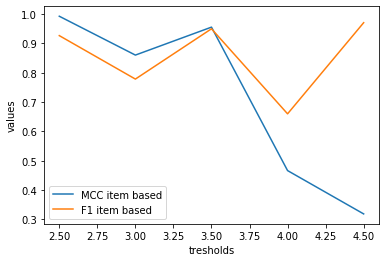

In [112]:
tresholds = [2.5, 3.0, 3.5, 4.0, 4.5]

recommended_item = [recommended(testing, t) for t in tresholds]
hidden_item = [hidden(testing, t) for t in tresholds]
used_item = [used(testing, t) for t in tresholds]
unused_item = [unused(testing, t) for t in tresholds]
item_conf = [confusion(recommended_item[i], hidden_item[i], used_item[i], unused_item[i]) for i in range(len(used_item))]
f1_score = [precision(ic) for ic in item_conf]
mcc_score = [recall(ic) for ic in item_conf]

plt.plot(tresholds, mcc_score)
plt.plot(tresholds, f1_score)

plt.xlabel('tresholds')
plt.ylabel('values')

plt.legend(['MCC item based','F1 item based'], loc = 'lower left')

## User based

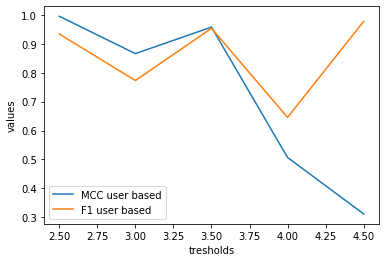

In [113]:


tresholds = [2.5, 3.0, 3.5, 4.0, 4.5]

recommended_item = [recommended(ub_testing, t) for t in tresholds]
hidden_item = [hidden(ub_testing, t) for t in tresholds]
used_item = [used(ub_testing, t) for t in tresholds]
unused_item = [unused(ub_testing, t) for t in tresholds]
item_conf = [confusion(recommended_item[i], hidden_item[i], used_item[i], unused_item[i]) for i in range(len(used_item))]
f1_score = [precision(ic) for ic in item_conf]
mcc_score = [recall(ic) for ic in item_conf]

plt.plot(tresholds, mcc_score)
plt.plot(tresholds, f1_score)

plt.xlabel('tresholds')
plt.ylabel('values')

plt.legend(['MCC user based','F1 user based'], loc = 'lower left')

## Random voorspellingen

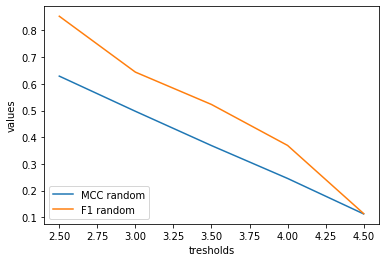

In [114]:
from random import randint
random_predict =  x_ub.loc[:,['user_id', 'business_id', 'stars']]
x = len(random_predict)
randomlist = []
for i in range(x):
    n = randint(10,50) / 10
    randomlist.append(n)
random_predict['predicted rating'] = randomlist

tresholds = [2.5, 3.0, 3.5, 4.0, 4.5]

recommended_item = [recommended(random_predict, t) for t in tresholds]
hidden_item = [hidden(random_predict, t) for t in tresholds]
used_item = [used(random_predict, t) for t in tresholds]
unused_item = [unused(random_predict, t) for t in tresholds]
item_conf = [confusion(recommended_item[i], hidden_item[i], used_item[i], unused_item[i]) for i in range(len(used_item))]
f1_score = [precision(ic) for ic in item_conf]
mcc_score = [recall(ic) for ic in item_conf]

plt.plot(tresholds, mcc_score)
plt.plot(tresholds, f1_score)

plt.xlabel('tresholds')
plt.ylabel('values')

plt.legend(['MCC random','F1 random'], loc = 'lower left')

## Content based(text)

([0.9909658191301108,
  0.760650535501785,
  0.9911423335369578,
  0.784981684981685,
  0.9986559139784946],
 [0.9997181245889317,
  0.9397236107027345,
  0.9894801036743406,
  0.3690373686929568,
  0.9611901681759379])

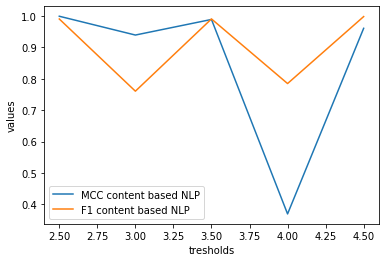

In [115]:
import matplotlib.pyplot as plt

tresholds = [2.5, 3.0, 3.5, 4.0, 4.5]

recommended_item = [recommended(predicted, t) for t in tresholds]
hidden_item = [hidden(predicted, t) for t in tresholds]
used_item = [used(predicted, t) for t in tresholds]
unused_item = [unused(predicted, t) for t in tresholds]
item_conf = [confusion(recommended_item[i], hidden_item[i], used_item[i], unused_item[i]) for i in range(len(used_item))]
f1_score = [precision(ic) for ic in item_conf]
mcc_score = [recall(ic) for ic in item_conf]

plt.plot(tresholds, mcc_score)
plt.plot(tresholds, f1_score)

#plt.xlim(0.0, 1.0)
#plt.ylim(0.3, 1.0)
plt.xlabel('tresholds')
plt.ylabel('values')

plt.legend(['MCC content based NLP','F1 content based NLP'], loc = 'lower left')

f1_score, mcc_score


## Content based(categories)

([0.8633333333333333,
  0.6819775837172523,
  0.7768386980758857,
  0.7354545454545455,
  0.9913793103448276],
 [0.997370151216305,
  0.9417909030481436,
  0.6583358732093874,
  0.127381514722091,
  0.07433742727860375])

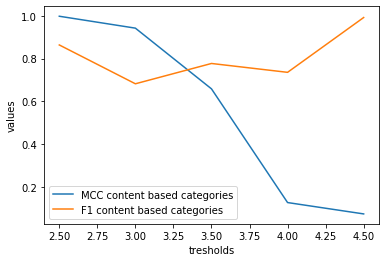

In [116]:
import matplotlib.pyplot as plt

tresholds = [2.5, 3.0, 3.5, 4.0, 4.5]

recommended_item = [recommended(calculated, t) for t in tresholds]
hidden_item = [hidden(calculated, t) for t in tresholds]
used_item = [used(calculated, t) for t in tresholds]
unused_item = [unused(calculated, t) for t in tresholds]
item_conf = [confusion(recommended_item[i], hidden_item[i], used_item[i], unused_item[i]) for i in range(len(used_item))]
f1_score = [precision(ic) for ic in item_conf]
mcc_score = [recall(ic) for ic in item_conf]

plt.plot(tresholds, mcc_score)
plt.plot(tresholds, f1_score)

#plt.xlim(0.0, 1.0)
#plt.ylim(0.3, 1.0)
plt.xlabel('tresholds')
plt.ylabel('values')

plt.legend(['MCC content based categories','F1 content based categories'], loc = 'lower left')

f1_score, mcc_score

## Combined

C:\Users\timzw\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: MatplotlibDeprecationWarning: Unrecognized location 'bottom left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


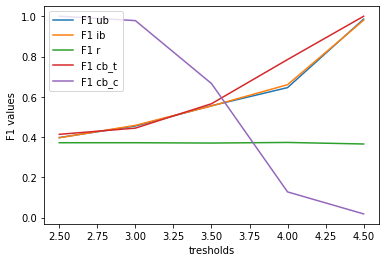

In [117]:
import matplotlib.pyplot as plt
from random import randint

tresholds = [2.5, 3.0, 3.5, 4.0, 4.5]
# USER BASED
recommended_item = [recommended(ub_testing, t) for t in tresholds]
hidden_item = [hidden(ub_testing, t) for t in tresholds]
used_item = [used(ub_testing, 4) for t in range(len(tresholds))]
unused_item = [unused(ub_testing, 4) for t in range(len(tresholds))]
item_conf = [confusion(recommended_item[i], hidden_item[i], used_item[i], unused_item[i]) for i in range(len(used_item))]
f1_score = [precision(ic) for ic in item_conf]

plt.plot(tresholds, f1_score)

# ITEM BASED
recommended_item = [recommended(testing, t) for t in tresholds]
hidden_item = [hidden(testing, t) for t in tresholds]
used_item = [used(testing, 4) for t in range(len(tresholds))]
unused_item = [unused(testing, 4) for t in range(len(tresholds))]
item_conf = [confusion(recommended_item[i], hidden_item[i], used_item[i], unused_item[i]) for i in range(len(used_item))]
f1_score = [precision(ic) for ic in item_conf]

plt.plot(tresholds, f1_score)

# RANDOM
random_predict =  x_ub.loc[:,['user_id', 'business_id', 'stars']]
x = len(random_predict)
randomlist = []
for i in range(x):
    n = randint(10,50) / 10
    randomlist.append(n)
random_predict['predicted rating'] = randomlist

recommended_item = [recommended(random_predict, t) for t in tresholds]
hidden_item = [hidden(random_predict, t) for t in tresholds]
used_item = [used(random_predict, 4) for t in range(len(tresholds))]
unused_item = [unused(random_predict, 4) for t in range(len(tresholds))]
item_conf = [confusion(recommended_item[i], hidden_item[i], used_item[i], unused_item[i]) for i in range(len(used_item))]
f1_score = [precision(ic) for ic in item_conf]

plt.plot(tresholds, f1_score)


# CONTENT BASED
recommended_item = [recommended(predicted, t) for t in tresholds]
hidden_item = [hidden(predicted, t) for t in tresholds]
used_item = [used(predicted, 4) for t in range(len(tresholds))]
unused_item = [unused(predicted, 4) for t in range(len(tresholds))]
item_conf = [confusion(recommended_item[i], hidden_item[i], used_item[i], unused_item[i]) for i in range(len(used_item))]
f1_score = [precision(ic) for ic in item_conf]

plt.plot(tresholds, f1_score)

# CONTENT BASED categories
recommended_item = [recommended(calculated, t) for t in tresholds]
hidden_item = [hidden(calculated, t) for t in tresholds]
used_item = [used(calculated, 4) for t in range(len(tresholds))]
unused_item = [unused(calculated, 4) for t in range(len(tresholds))]
item_conf = [confusion(recommended_item[i], hidden_item[i], used_item[i], unused_item[i]) for i in range(len(used_item))]
mcc_score = [recall(ic) for ic in item_conf]

plt.plot(tresholds, mcc_score)

plt.xlabel('tresholds')
plt.ylabel('F1 values')

# ub = user based, ib = item based, cb = content based, r = random
plt.legend(['F1 ub', 'F1 ib', 'F1 r','F1 cb_t','F1 cb_c'], loc = 'bottom left')

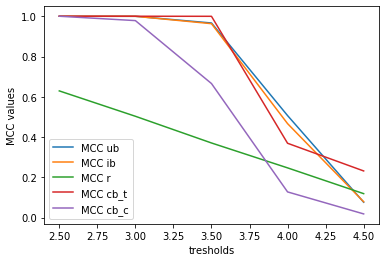

In [118]:
import matplotlib.pyplot as plt
from random import randint

tresholds = [2.5, 3.0, 3.5, 4.0, 4.5]
# USER BASED
recommended_item = [recommended(ub_testing, t) for t in tresholds]
hidden_item = [hidden(ub_testing, t) for t in tresholds]
used_item = [used(ub_testing, 4) for t in range(len(tresholds))]
unused_item = [unused(ub_testing, 4) for t in range(len(tresholds))]
item_conf = [confusion(recommended_item[i], hidden_item[i], used_item[i], unused_item[i]) for i in range(len(used_item))]
mcc_score = [recall(ic) for ic in item_conf]

plt.plot(tresholds, mcc_score)

# ITEM BASED
recommended_item = [recommended(testing, t) for t in tresholds]
hidden_item = [hidden(testing, t) for t in tresholds]
used_item = [used(testing, 4) for t in tresholds]
unused_item = [unused(testing, 4) for t in tresholds]
item_conf = [confusion(recommended_item[i], hidden_item[i], used_item[i], unused_item[i]) for i in range(len(used_item))]
mcc_score = [recall(ic) for ic in item_conf]

plt.plot(tresholds, mcc_score)


recommended_item = [recommended(random_predict, t) for t in tresholds]
hidden_item = [hidden(random_predict, t) for t in tresholds]
used_item = [used(random_predict, 4) for t in tresholds]
unused_item = [unused(random_predict, 4) for t in tresholds]
item_conf = [confusion(recommended_item[i], hidden_item[i], used_item[i], unused_item[i]) for i in range(len(used_item))]
mcc_score = [recall(ic) for ic in item_conf]

plt.plot(tresholds, mcc_score)


# CONTENT BASED text
recommended_item = [recommended(predicted, t) for t in tresholds]
hidden_item = [hidden(predicted, t) for t in tresholds]
used_item = [used(predicted, 4) for t in tresholds]
unused_item = [unused(predicted, 4) for t in tresholds]
item_conf = [confusion(recommended_item[i], hidden_item[i], used_item[i], unused_item[i]) for i in range(len(used_item))]
mcc_score = [recall(ic) for ic in item_conf]

plt.plot(tresholds, mcc_score)

# CONTENT BASED categories
recommended_item = [recommended(calculated, t) for t in tresholds]
hidden_item = [hidden(calculated, t) for t in tresholds]
used_item = [used(calculated, 4) for t in tresholds]
unused_item = [unused(calculated, 4) for t in tresholds]
item_conf = [confusion(recommended_item[i], hidden_item[i], used_item[i], unused_item[i]) for i in range(len(used_item))]
mcc_score = [recall(ic) for ic in item_conf]

plt.plot(tresholds, mcc_score)


plt.xlabel('tresholds')
plt.ylabel('MCC values')

# ub = user based, ib = item based, cb = content based, r = random
plt.legend(['MCC ub', 'MCC ib', 'MCC r','MCC cb_t', 'MCC cb_c'], loc = 'lower left')

## MSE / accuracy tabel

In [119]:

tabel = pd.DataFrame(index=['content based','item based','user based'])
tabel['MSE'] = [mse_cb,ib_mse,ub_mse]
tabel['accuracy'] = [cb_acc,ib_acc,ub_acc]

tabel

,MSE,accuracy
content based,0.614934,0.670410
item based,0.189354,0.713773
user based,0.181625,0.713889
